In [4]:
# %matplotlib inline

import dill
from collections import defaultdict, Counter
import numpy as np
import random
import matplotlib.pyplot as plt
from datetime import datetime

In [5]:
#read the training files and concatenate to create the training corpus

##english
train_e = 'training/hansards.36.2.e'
test_e = 'testing/test/test.e'
dev_e = 'validation/dev.e'
# train_e = 'training/eng.e'

##french
train_f = 'training/hansards.36.2.f'
test_f = 'testing/test/test.f'
dev_f = 'validation/dev.f'
# train_f = 'training/fra.f'

null = ['0NULL']

with open(train_e) as e:
    sentences_e = [null + l.split() for l in e.readlines()]

with open(test_e) as e:
    for l in e.readlines():
         sentences_e.append(null + l.split())

with open(dev_e) as e:
    for l in e.readlines():
         sentences_e.append(null + l.split())

    
with open(train_f) as f:
    sentences_f = [l.split() for l in f.readlines()]

with open(test_f) as f:
    for l in f.readlines():
         sentences_f.append(l.split())

with open(dev_f) as f:
    for l in f.readlines():
         sentences_f.append(l.split())

no_sentences = len(sentences_e)
print(no_sentences)

231648


In [6]:
#Here we preprocessed the corpus by replacing all the words that occur only once with <UNK>  
#these corpora were not used in further experiments

en_cnt = Counter()
for sent in sentences_e:
    for word in sent:
        en_cnt[word.lower()] += 1

new_sentences_e = []
for sent in sentences_e:
    sent = ['<UNK>' if en_cnt[word.lower()] == 1 else word for word in sent]
    new_sentences_e.append(sent)

fr_cnt = Counter()
for sent in sentences_f:
    for word in sent:
        fr_cnt[word.lower()] += 1

new_sentences_f = []
for sent in sentences_f:
    sent = ['<UNK>' if fr_cnt[word.lower()] == 1 else word for word in sent]
    new_sentences_f.append(sent)

In [7]:
#INIT TRANSLATION PROBABILITY
# - randomly (3x)
# - uniformly
# - with the final results from IBM1

t = defaultdict(lambda: defaultdict(int)) #create dictionary of transition probabilities

for i in range (no_sentences):
    sent_e = sentences_e[i] #new_sentences_e[i]
    sent_f = sentences_f[i] #new_sentences_f[i]
    
    for word_e in sent_e:
        for word_f in sent_f:
            #initialize the translation probabilities t(f|e) randomly
            t[word_f.lower()][word_e.lower()] = random.random()
            

In [8]:
max_jump = 100
jump_dist = 1. / (2 * max_jump) * np.ones([1, 2 * max_jump])

In [9]:
def jump_func(i, j, m, n):
    """
    Alignment of french word j to english word i. 
    i = 0, to ,m  (we use m as in Wilker's lecture slides -- length of English sentence)
    j = 1, to ,n  (we use n as in Wilker's lecture slides -- length of French sentence)
    That is: a_j = i
    with e.g. max_jump = 100
    from[-max_jump, max_jump] to [0, 2*max_jump + 1] 
    """
    # We normalise j by the length of the French sentence and scale the result to the length of the English sentence
    # this gives us a continuous value that is an interpolation of where we j would be in the English sentence
    # if alignments were a linear function of the length ratio
    jump = np.floor(i - (j * m / n)) 
    # then we collapse all jumps that are too far to the right to the maximum jump value allowed
    if jump >= max_jump:  # or we collapse all jumps that are too far to the left to the maximum (negative) jump allowed
        jump = max_jump - 1  
    elif jump < -max_jump: #this does not need equality
        jump = -max_jump
    # Now we shift the jump values so they start from 0
    #  this is only necessary if you use python lists or numpy vectors to store jump probabilities
    #  otherwise, you can use a python dict and this shifting is not required since dicts can have negative keys
    return jump + max_jump

In [10]:
#max_jump = 100
jump_dist[0, int(jump_func(2, 1, 12, 12))]

0.0050000000000000001

In [11]:
#Init with results from IBM1
with open('transprobs_9.pickle', 'rb') as f:
    t = dill.load(f)
    

In [15]:
#INIT ALIGNMENT PROBABILITIES
q = defaultdict(lambda: defaultdict(int))
vocab_size = 43196

#Initialization of the q probabilities
for sent in range(no_sentences):
    sent_e = sentences_e[sent] #new_sentences_e[sent]
    sent_f = sentences_f[sent] #new_sentences_f[sent]
    
    m = len(sent_f) 
    l = len(sent_e)
    
    for i in range(m): #english
        for j in range(l): #french
            q[j][(i,l,m)] = random.random()
    


In [84]:
with open('alignprobs_init_random.pickle', 'rb') as f:
    q = dill.load(f)

In [7]:
dev_e = 'validation/dev.e'
# test_e = 'testing/test/test.e'
dev_f = 'validation/dev.f'
# test_f = 'testing/test/test.f'

with open(dev_e) as e:
    val_sentences_e = [null + l.split() for l in e.readlines()]
with open(dev_f) as f:
    val_sentences_f = [l.split() for l in f.readlines()]

num_val_sentences = len(val_sentences_e)
print(num_val_sentences)

37


this is iteration  0
-3762.0295622
this is iteration  1
-2597.18404836
this is iteration  2
-2280.22435105
this is iteration  3
-2199.8179577
this is iteration  4
-2185.46984305
this is iteration  5


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:85: RuntimeWarning: divide by zero encountered in log


-2184.31489906
this is iteration  6
-2187.63843729
this is iteration  7
-2211.07547756
this is iteration  8
-2220.18853587
this is iteration  9
-2243.88200424


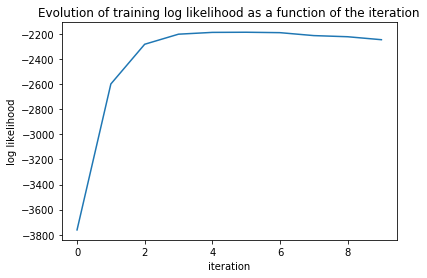

In [11]:
# IBM model 2 with jump function EM training

likelihood_list = [] #here we will store the likelihoods per iteration

#We initialize q uniformly
max_jump = 100
jump_dist = 1. / (2 * max_jump) * np.ones([1, 2 * max_jump])

#We initialize t as the results of training IBM1
with open('transprobs_init.pickle', 'rb') as f:
    t = dill.load(f)
    
num_iterations = 10

for v in range(num_iterations):
    print('this is iteration ',v)
    counts_ef = defaultdict(lambda: defaultdict(int))
    counts_e = defaultdict(int)
    counts_jump = defaultdict(int)
    
    for k in range(100):
        sent_f = sentences_f[k]
        m = len(sent_f)
        
        sent_e = sentences_e[k]
        l = len(sent_e)
        
        ##E-step
        #Compute normalizer
        for i in range(m):
            Z = 0
            for j in range(l):
                word_z = t[sent_f[i].lower()][sent_e[j].lower()] * jump_dist[0, int(jump_func(j, i, l, m))]
                Z += word_z
                
            #Increment the counts with delta
            
            for j in range(l):
                
                delta = (t[sent_f[i].lower()][sent_e[j].lower()] * jump_dist[0, int(jump_func(j, i, l, m))]) / Z

                counts_ef[sent_f[i].lower()][sent_e[j].lower()] += delta
                
                counts_e[sent_e[j].lower()] += delta

                counts_jump[int(jump_func(j,i,l,m))] += delta
        
        ##M-step
        
        for i in range(m):
            
            div_q = 0
            
            for j in range(l):
                
                t[sent_f[i].lower()][sent_e[j].lower()] = counts_ef[sent_f[i].lower()][sent_e[j].lower()] / counts_e[sent_e[j].lower()]
                
                div_q += counts_jump[int(jump_func(j,i,l,m))]
            
            for j in range(l):
                
                jump_dist[0, int(jump_func(j, i, l, m))] = counts_jump[int(jump_func(j,i,l,m))] / div_q 
                
        
    #Compute the log likelihood
    likelihood = 0
    
    for k in range(100):
        sent_f = sentences_f[k]
        m = len(sent_f)
        
        sent_e = sentences_e[k]
        l = len(sent_e)
        
        sent_likelihood = 0 

        for i in range(m):

            word_likelihood = -9999

            best_j = -1 #to be set after the loop below

            for j in range(l):

                temp_likelihood = np.log(t[sent_f[i].lower()][sent_e[j].lower()]) + np.log(jump_dist[0, int(jump_func(j, i, l, m))])
                
                if word_likelihood == -9999 or temp_likelihood > word_likelihood:

                    word_likelihood = temp_likelihood
                    best_j = j #we can use this part for decoding later
                    
            sent_likelihood += word_likelihood
    
        likelihood += sent_likelihood

    print(likelihood)

    likelihood_list.append(likelihood)
    
    #Here we write out the NAACL files on the validation set 
#     filename = "val_naacl_IBM2_uniform_iter" + str(v) +".txt"
#     write_val_results(filename)
    
    
#Here we plot the log likelihoods per iteration    
iteration= list(range(len(likelihood_list)))

plt.plot(iteration, likelihood_list)
plt.xlabel("iteration")
plt.ylabel('log likelihood')
plt.title('Evolution of training log likelihood as a function of the iteration')
# plt.savefig("EM_IBM2_initIBM1.png")
plt.show()

In [17]:
# IBM model 2 with EM training (without jump function) -- NOT WORKING DUE TO SPARSITY (deltas become 0)

#We initialize q as random values and t as the results of training IBM1
with open('alignprobs_init_random.pickle', 'rb') as f:
    q = dill.load(f)

with open('transprobs_9.pickle', 'rb') as f:
    t = dill.load(f)
    
num_iterations = 10

for k in range(num_iterations):
    print('this is iteration ',k)
    counts_ef = defaultdict(lambda: defaultdict(int))
    counts_e = defaultdict(int)
    counts_jilm = defaultdict(lambda: defaultdict(int))
    counts_ilm = defaultdict(int)
    
    for k in range(1000):
        sent_f = sentences_f[k]
        m = len(sent_f)
        
        sent_e = sentences_e[k]
        l = len(sent_e)
        
        ##E-step
        #Compute normalizer
        for i in range(m):
            Z = 0
            for j in range(l):
                word_z = t[sent_e[j].lower()][sent_f[i].lower()] * q[j][(i,l,m)]
                Z += word_z
                
            #Increment the counts with delta
            
            for j in range(l):
                
                delta = (t[sent_f[i].lower()][sent_e[j].lower()] * q[j][(i,l,m)]) / Z
#                 if delta == 0:
#                     delta = 0.00000000000000000000001
                
                counts_ef[sent_f[i].lower()][sent_e[j].lower()] += delta
                
                counts_e[sent_e[j].lower()] += delta
                
                counts_jilm[j][(i,l,m)] += delta
                
                counts_ilm[(i,l,m)] += delta
        
        ##M-step
        for i in range(m):
            for j in range(l):
                
                t[sent_f[i].lower()][sent_e[j].lower()] = counts_ef[sent_f[i].lower()][sent_e[j].lower()] / counts_e[sent_e[j].lower()]
                
                q[j][(i,l,m)] = counts_jilm[j][(i,l,m)] / counts_ilm[(i,l,m)]
                
                
                
                

this is iteration  0
this is iteration  1
this is iteration  2
this is iteration  3
this is iteration  4


ZeroDivisionError: float division by zero

In [10]:
#Run this after training to save the translation and alignment probabilities!!!!! 

filename = 'IBM2_uniform_transprobs_' + str(k) + '.pickle'                   
with open(filename, 'wb') as f:
    dill.dump(t,f)

filename = 'IBM2_uniform_alignprobs_' + str(k) + '.pickle'                   
with open(filename, 'wb') as f:
    dill.dump(jump_dist,f)

In [8]:
#Decoding with IBM model 2
#we try to find the most probable alignment given the translation 
#probabilities that were trained with the EM steps
#for each word in a sentence, find highest combination of t and q 

def write_val_results(filename):
    naaclfile = open(filename,"w") 
    for sent in range(num_val_sentences):
        sent_e = val_sentences_e[sent]
        sent_f = val_sentences_f[sent]

        l = len(sent_e) #includes null
        m = len(sent_f)

        for i in range(m):
            best_prob = 0
            best_j = 0
            for j in range(l):
                if (t[sent_f[i].lower()][sent_e[j].lower()] * jump_dist[0, int(jump_func(j, i, l, m))]) > best_prob:
                    best_prob = t[sent_f[i].lower()][sent_e[j].lower()] * jump_dist[0, int(jump_func(j, i, l, m))]
                    best_j = j
            if best_j != 0:
                naaclfile.write(str(sent+1) + " " + str(best_j) + " " + str(i+1) + " S" + "\n")
    naaclfile.close()

In [26]:
filename = 'IBM2_uniform_alignprobs_231647.pickle'
with open(filename, 'rb') as f:
    t = dill.load(f)
    
filename = 'IBM2_uniform_transprobs_231647.pickle'
with open(filename, 'rb') as f:
    jump_dist = dill.load(f)

In [14]:
test_e = 'testing/test/test.e'
test_f = 'testing/test/test.f'

with open(test_e) as e:
    test_sentences_e = [null + l.split() for l in e.readlines()]
with open(test_f) as f:
    test_sentences_f = [l.split() for l in f.readlines()]

num_test_sentences = len(test_sentences_e)
print(num_test_sentences)

447


In [15]:
#Decoding with IBM model 2
#we try to find the most probable alignment given the translation 
#probabilities that were trained with the EM steps
#for each word in a sentence, find highest combination of t and q 

def write_test_results(filename):
    naaclfile = open(filename,"w") 
    for sent in range(num_test_sentences):
        sent_e = test_sentences_e[sent]
        sent_f = test_sentences_f[sent]

        l = len(sent_e) #includes null
        m = len(sent_f)

        for i in range(m):
            best_prob = 0
            best_j = 0
            for j in range(l):
                if (t[sent_f[i].lower()][sent_e[j].lower()] * jump_dist[0, int(jump_func(j, i, l, m))]) > best_prob:
                    best_prob = t[sent_f[i].lower()][sent_e[j].lower()] * jump_dist[0, int(jump_func(j, i, l, m))]
                    best_j = j
            if best_j != 0:
                naaclfile.write(str(sent+1) + " " + str(best_j) + " " + str(i+1) + " S" + "\n")
    naaclfile.close()

In [16]:
write_test_results('naacl_IBM2_uniform_iter9')